#1 Detecção de Anomalias

Para analisar o comportamento de servidores em um data center, serão analisados dados coletados relativos à vazão em mb/s e latência em ms. Inicialmente, carregamos os dados e geramos uma visualização básica da dispersão das características.

In [1]:
#Importação de bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.optimize as opt
import scipy.io as spio
from google.colab import files

In [2]:

arquivo = files.upload()

data = spio.loadmat('ex8data1.mat')

Saving ex8data1.mat to ex8data1.mat


In [3]:
#Conferência dos dados
#Saída muito extensa - Comentada para uso apenas para na conferência
#print(data)

#Carga dos subconjuntos de treino, teste e validação
X = np.array(data['X'])

X_val = np.array(data['Xval'])
y_val = data['yval'].flatten()

In [4]:
#Conferência da dimensão do conjunto de dados
print(X.shape, X_val.shape, y_val.shape)

(307, 2) (307, 2) (307,)


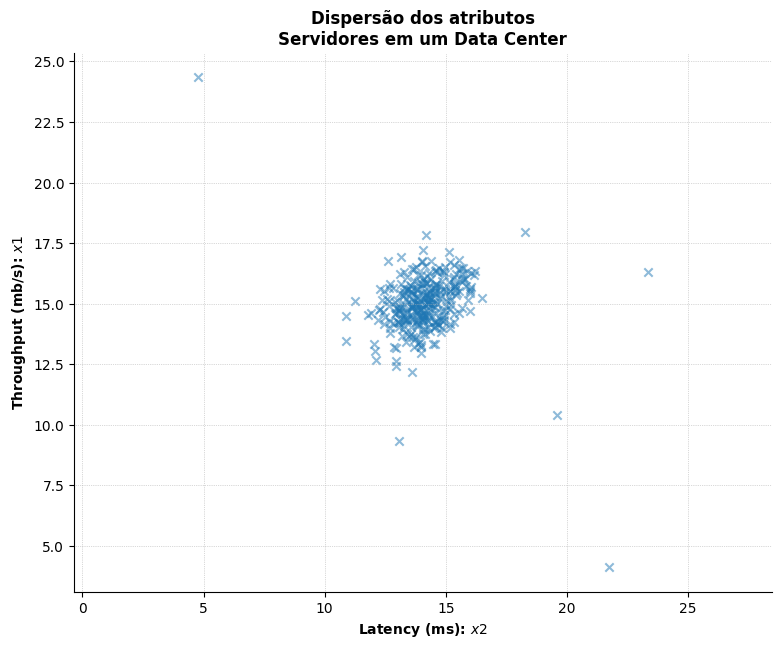

In [6]:
plt.figure(figsize=(9,7))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

#Dispersão dos dados
plt.scatter(X[:,0], X[:,1], marker='x', alpha=0.5)


#Configurações visuais adicionais
plt.title('Dispersão dos atributos\nServidores em um Data Center',
          fontweight='bold')
plt.ylabel('Throughput (mb/s): $x1$', fontweight='bold')
plt.xlabel('Latency (ms): $x2$', fontweight='bold')
plt.axis('equal')
sns.despine()

#plt.savefig('target/plot4.png')

#1.1 Distribuição Gaussiana

Nesta seção vamos analisar os dados em mais detalhes e na sequência, para identificar anomalias, vamos estimar parâmetros para a distribuição *gaussiana*.

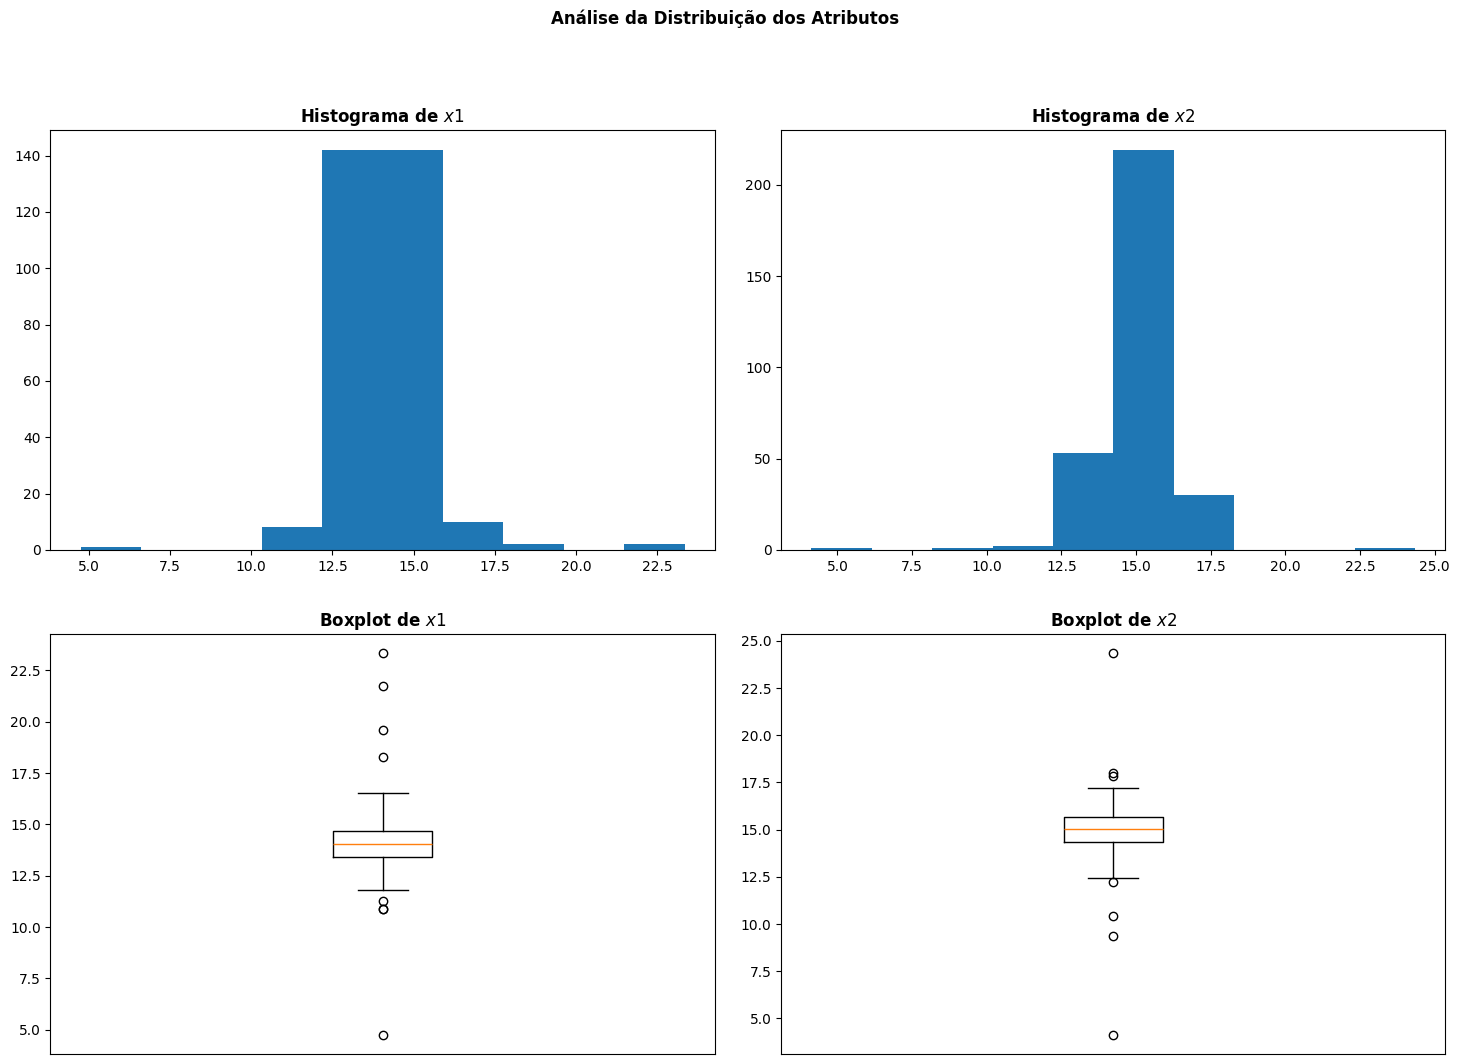

In [7]:
fig = plt.figure(figsize=(18,12))
fig.suptitle('Análise da Distribuição dos Atributos', fontweight='bold')

#Criação dos subplots
ax1 = fig.add_subplot(2,2,1)
ax2 = fig.add_subplot(2,2,2)
ax3 = fig.add_subplot(2,2,3)
ax4 = fig.add_subplot(2,2,4)


#Histogramas
ax1.hist(X[:,0])
ax1.set_title('Histograma de $x1$', fontweight='bold')

ax2.hist(X[:,1])
ax2.set_title('Histograma de $x2$', fontweight='bold')


#Boxplots
ax3.boxplot(X[:,0])
ax3.set_title('Boxplot de $x1$', fontweight='bold')

ax4.boxplot(X[:,1])
ax4.set_title('Boxplot de $x2$', fontweight='bold')


#Configurações visuais adicionais
ax3.set_xticks([])
ax4.set_xticks([])
plt.subplots_adjust(wspace=0.1)

#plt.savefig('target/plot4.1.1.png')

As visualizações acima já permitem uma primeira intuição da existência de *outliers* no conjunto de dados, como podem ser vistos nos pontos fora dos limites inferiores e superiores de outliers, bem como pelas observações existentes em faixas de valores afastadas dos pontos médios de cada histograma.

#1.2 Estimativa de parâmetros para uma gaussiana

Para prosseguir a análise será implementada uma função do zero para estimativa dos parâmetros da distribuição *gaussiana*.

In [8]:
def estimate_gaussian_params(X):
  """
  Essa funcao deve computar e retornar mu e sigma2,
  vetores que contem a media e a variancia de cada
  caracteristica (feature) de X.
  """
  ########################
  # SEU CODIGO AQUI :
  ########################
  mu = np.mean(X, axis=0)
  sigma2 = np.var(X, axis=0)

  return (mu, sigma2)

In [9]:
mu, sigma2 = estimate_gaussian_params(X)
print(f'mu:     {mu}\nsigma2: {sigma2}')

mu:     [14.11222578 14.99771051]
sigma2: [1.83263141 1.70974533]


Com a implementação chegamos aos vetore com os valores de $\mu$ e $\sigma^2$ apresentados na listagem anterior.

---

Agora plotaremos os a visualização dos contornos da distribuição *gaussiana* ajustada.

In [10]:
#Função implementada do repositório da disciplina sem alterações
# Source: https://github.com/Grzego/handwriting-generation/issues/16
def bivariate_normal(X, Y, sigmax=1.0, sigmay=1.0,
                     mux=0.0, muy=0.0, sigmaxy=0.0):
    """
    Bivariate Gaussian distribution for equal shape *X*, *Y*.
    See `bivariate normal
    <http://mathworld.wolfram.com/BivariateNormalDistribution.html>`_
    at mathworld.
    """
    Xmu = X-mux
    Ymu = Y-muy

    rho = sigmaxy/(sigmax*sigmay)
    z = Xmu**2/sigmax**2 + Ymu**2/sigmay**2 - 2*rho*Xmu*Ymu/(sigmax*sigmay)
    denom = 2*np.pi*sigmax*sigmay*np.sqrt(1-rho**2)
    return np.exp(-z/(2*(1-rho**2))) / denom

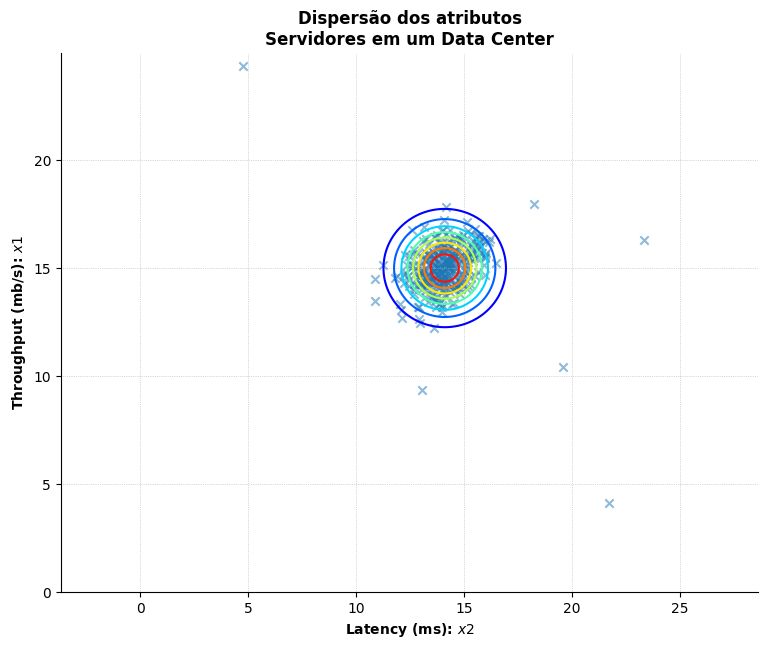

In [11]:
#Dados adicionais para construção dos contornos
x = np.arange(0, 25, .025)
y = np.arange(0, 25, .025)
first_axis, second_axis = np.meshgrid(x, y)

Z = bivariate_normal(first_axis, second_axis,
                     np.sqrt(sigma2[0]), np.sqrt(sigma2[1]),
                     mu[0], mu[1])

plt.figure(figsize=(9,7))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

#Dispersão dos dados
plt.scatter(X[:,0], X[:,1], marker='x', alpha=0.5)

#Contornos da Gaussiana
plt.contour(first_axis, second_axis, Z, 10, cmap=plt.cm.jet)

#Configurações visuais adicionais
plt.title('Dispersão dos atributos\nServidores em um Data Center',
          fontweight='bold')
plt.ylabel('Throughput (mb/s): $x1$', fontweight='bold')
plt.xlabel('Latency (ms): $x2$', fontweight='bold')
plt.axis('equal')
sns.despine()

#plt.savefig('target/plot4.2.png')

Nesta visualização os círculos plotados pelo contorno representam a distribuição gaussiana estimada para o conjunto de dados. Pode-se perceber que a maioria das observações estão dentro dos limites de maior probabilidade. Os valores fora destes limites tem menor probabilidade de ocorrência na distribuição *gaussiana* e por isso representam anomalias.

#1.3 Selecionando $\epsilon$

Para investigar a existência no conjunto de dados de maneira mais direta, classificando os pontos de acordo com sua probabilidade de pertencimento à distribuição *gaussiana*, será selecionado um limite identificado por $\epsilon$. Definido este limite a identificação dos pontos que representam anomalias é dada por:

* Se $Pr(x) < \epsilon$, então $x$ é anomalia

---

A função `select_epsilon` implementa a definição do $\epsilon$.

In [12]:
#Preparação dos dados adicionais
from scipy import stats

#Cálculo do desvio padrão dos dados
stddev = np.sqrt(sigma2)

#Cálculo da probabilidade - Usando conjunto de validação
pval = np.zeros((X_val.shape[0], X_val.shape[1]))
pval[:,0] = stats.norm.pdf(X_val[:,0], mu[0], stddev[0])
pval[:,1] = stats.norm.pdf(X_val[:,1], mu[1], stddev[1])

#Conferência da dimensão
print(np.prod(pval, axis=1).shape)

(307,)


In [13]:
pval[:5]

array([[0.13668804, 0.30457725],
       [0.27727265, 0.29540963],
       [0.25238744, 0.16132253],
       [0.27314666, 0.22661829],
       [0.26277866, 0.27090007]])

In [14]:
#Personalização da função select_epsilon
from sklearn.metrics import f1_score

def select_epsilon(pval, yval):
  best_epsilon_value = 0
  best_f1_value = 0

  step_size = (pval.max() - pval.min()) / 1000

  #print('step size: ' + str(step_size))

  for epsilon in np.arange(pval.min(), pval.max(), step_size):
      preds = pval < epsilon
      f = f1_score(y_val, preds)

      if f > best_f1_value:
        best_f1_value = f
        best_epsilon_value = epsilon

  return best_epsilon_value, best_f1_value

In [15]:
epsilon, _ = select_epsilon(np.prod(pval, axis=1), y_val)
print('Best value found for epsilon: ' + str(epsilon))

Best value found for epsilon: 8.990852779269493e-05


Por fim, aplicamos a função para identificação do limite *epsilon* para detectar as anomalias no conjunto de dados analisado. As anomalias detectadas estão marcadas em vermelho na visualização a seguir.

<Figure size 640x480 with 0 Axes>

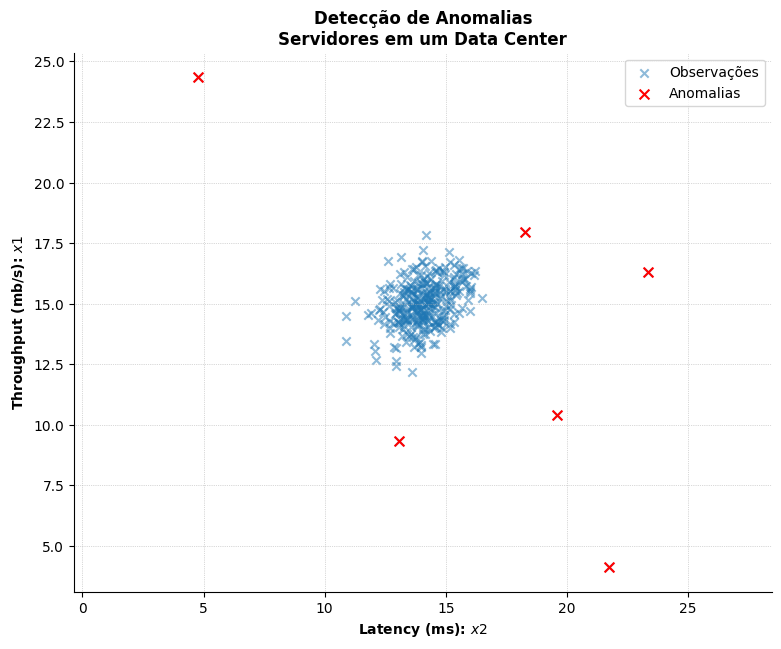

In [16]:
#Dados adicionais para detecção das anomalias
p = np.zeros((X.shape[0], X.shape[1]))
p[:,0] = stats.norm.pdf(X[:,0], mu[0], stddev[0])
p[:,1] = stats.norm.pdf(X[:,1], mu[1], stddev[1])

#Aplicação do modelo para detecção de anomalias nos exemplos de X
anomalies = np.where(np.prod(p, axis=1) < epsilon)

plt.clf()
plt.figure(figsize=(9,7))
plt.grid(color='0.7', linestyle=':', linewidth=0.5)

#Dispersão dos dados
plt.scatter(X[:,0], X[:,1], marker='x', alpha=0.5, label='Observações')

#Detecção das anomalias
plt.scatter(X[anomalies[0],0], X[anomalies[0],1], s=50,
            color='r', marker='x', label='Anomalias')

#Configurações visuais adicionais
plt.title('Detecção de Anomalias\nServidores em um Data Center',
          fontweight='bold')
plt.ylabel('Throughput (mb/s): $x1$', fontweight='bold')
plt.xlabel('Latency (ms): $x2$', fontweight='bold')
plt.axis('equal')
plt.legend(loc='best')
sns.despine()

#plt.savefig('target/plot4.3.png')